# Проект: Анализ оттока клиентов банка

## Шаг 1. Загрузка данных.

In [1]:
import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

from scipy import stats as st
from scipy.stats import ttest_ind

pd.options.display.float_format = '{:,.1f}'.format

In [2]:
try:
    data = (
        pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv'))
        
except:
    data = (
        pd.read_csv('bank_scrooge.csv'))

In [3]:
data.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.0,Рыбинск,Ж,25.0,1,"59,214.8",2,0,1,"75,719.1",1
1,146556,861.0,Рыбинск,Ж,37.0,5,"850,594.3",3,1,0,"86,621.8",0
2,120722,892.0,Рыбинск,Ж,30.0,0,NaN,1,1,1,"107,683.3",0
3,225363,866.0,Ярославль,Ж,51.0,5,"1,524,746.3",2,0,1,"174,423.5",1
4,157978,730.0,Ярославль,М,34.0,5,174.0,1,1,0,"67,353.2",1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Всего в датасете представлена информация о 10 000 клиентах. Видны пропуски в столбцах про возраст и баланс и тип данных в нескольких столбцах стоит поменять на булевой.

## Шаг 2. Предобработка данных.

Сначала посчитаем кол-во и процент пропусков.

In [5]:
data.isna().sum().sort_values(ascending=False)

balance          2295
age                26
USERID              0
score               0
city                0
gender              0
equity              0
products            0
credit_card         0
last_activity       0
EST_SALARY          0
churn               0
dtype: int64

In [6]:
(data.isna().mean()*100).sort_values(ascending=False)

balance         22.9
age              0.3
USERID           0.0
score            0.0
city             0.0
gender           0.0
equity           0.0
products         0.0
credit_card      0.0
last_activity    0.0
EST_SALARY       0.0
churn            0.0
dtype: float64

Пропуски в балансе - почти 23%, мы не можем их ничем заполнить и также не можем удалить - это почти четверть данных, поэтому пропуски в балансе оставляем, как есть.

Пропуски в возраста - меньше 1%, предлагаю их оставить.

In [7]:
f"Всего полных дубликатов: {data.duplicated().sum()}"

'Всего полных дубликатов: 0'

Посмотрим на неявные дубликаты: посмотрим уникальные значения в колонках город и пол.

In [8]:
data['city'].unique()

array(['Рыбинск', 'Ярославль', 'Ростов'], dtype=object)

In [9]:
data['gender'].unique()

array(['Ж', 'М'], dtype=object)

С написанием все корректно. Далее посмотрим совпадения одновременно по идентификатору пользователя, возрасту, городу и полу.

In [10]:
data.loc[data.duplicated(subset=['USERID', 'age', 'city', 'gender'], keep=False)].count()

USERID           0
score            0
city             0
gender           0
age              0
equity           0
balance          0
products         0
credit_card      0
last_activity    0
EST_SALARY       0
churn            0
dtype: int64

Таких нет, поэтому можно переходить к столбцам - приведем их все к нижнему регистру.

In [11]:
data.columns = data.columns.str.lower()

In [12]:
data.columns

Index(['userid', 'score', 'city', 'gender', 'age', 'equity', 'balance',
       'products', 'credit_card', 'last_activity', 'est_salary', 'churn'],
      dtype='object')

Поменяем тип данных на булевой в столбцах churn, last_activity, credit_card.

In [13]:
data['churn']=data['churn'].astype('bool')

In [14]:
data['last_activity']=data['last_activity'].astype('bool')

In [15]:
data['credit_card']=data['credit_card'].astype('bool')

Проверим числовые значения на аномалии.

In [16]:
data['age'].describe()

count   9,974.0
mean       42.7
std        12.2
min        18.0
25%        33.0
50%        40.0
75%        51.0
max        86.0
Name: age, dtype: float64

<AxesSubplot:>

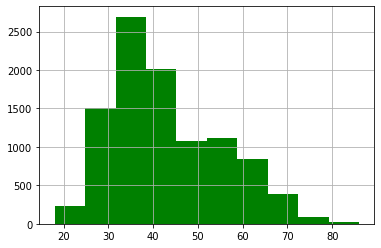

In [17]:
data['age'].hist(color='green')

В датасете нет детей (минимальное значение - 18) и нет аномально взрослых людей (максимальный возраст - 86), с данным все нормально.
Также по гистограмме можно увидеть, что большинство в датасете - клиенты от 30 до 40 лет.

In [18]:
data['balance'].describe()

count         7,705.0
mean        827,794.3
std       1,980,614.1
min               0.0
25%         295,554.2
50%         524,272.2
75%         980,705.8
max     119,113,552.0
Name: balance, dtype: float64

(0.0, 4827443.494)

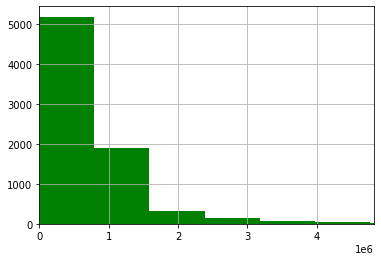

In [19]:
data['balance'].hist(bins=150, color='green')
plt.xlim(0,data['balance'].quantile(0.99))

Минимальное значение 0, счет может быть открыт, денег на нем нет. Максимальное значение - 119 миллионов.
Предположу, что у кого-то действительно могут лежать такие деньги на счете (вип-клиенты банка, например).
Из гистограммы видно, что у большинства клиентов на счету денег до 1 миллиона, 99% клиентов хранят суммы до 5 миллиона, остальной 1% - больше 5 миллионов.

In [20]:
data['est_salary'].describe()

count      10,000.0
mean      147,866.9
std       139,388.5
min         2,546.3
25%        75,251.9
50%       119,658.1
75%       174,500.5
max     1,395,064.4
Name: est_salary, dtype: float64

(0.0, 887903.8546000007)

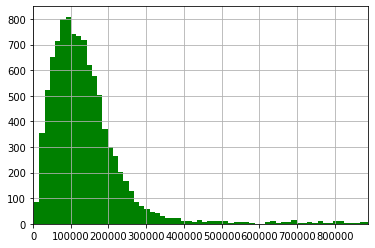

In [21]:
data['est_salary'].hist(bins=100, color='green')
plt.xlim(0,data['est_salary'].quantile(0.99))

Минимальное значение - 2546 ниже прожиточного минимума, но такое вполне возможно (работа не на полную ставку), поэтому оставляем.

Максимальное значение - 1 395 064 тоже кажется вполне возможным (помимо работы, у клиента могут быть дополнительные поступления, которые банк оценил как заработную плату, или, например, клиент может иметь высокодоходный бизнес и т.д.)

В ходе предобработки данных:

1) изучены явные и неявные дубликаты;

2) проанализированы пропуски в датасете;

3) названия столбцов приведены к нижнему регистру;

4) изменен тип данных в столбцах credit_card, last_activity, churn;

5) проверены числовые значения на аномалии.

## Шаг 3. Исследовательский анализ данных

Сначала построим корреляционную матрицу и посмотрим, есть ли у каких-либо показателей зависимость.

In [22]:
data['userid'] = data['userid'].astype('str')

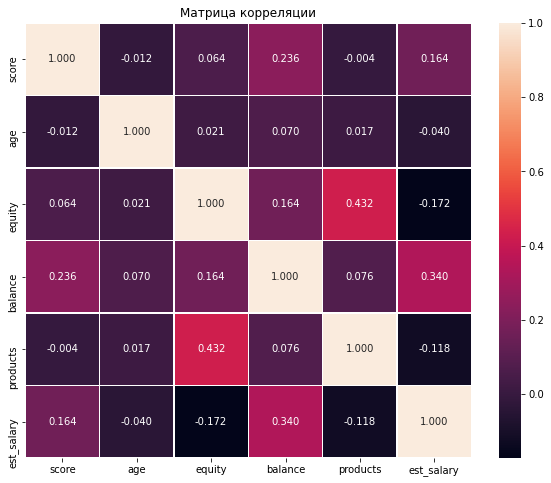

In [23]:
num_col = data.select_dtypes(include=['float64', 'int64']).columns

correlation_matrix = data[num_col].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='rocket', fmt='.3f', linewidths=0.5)
plt.title('Матрица корреляции')
plt.show()

Из всех показтелей можно выделить только небольшую зависимость между продуктами банка и баллами собственности, а также между балансом на счете и оценочной заработной платой.

Далле для отточных и оставшихся клиентов построим гистограммы распределения плотности вероятности по ряду показателей.

1) Распределение баллов скоринга среди оставшихся и отточных клиентов.

Text(0.5, 1.0, 'Распределение баллов скоринга среди отточных и оставшихся клиентов')

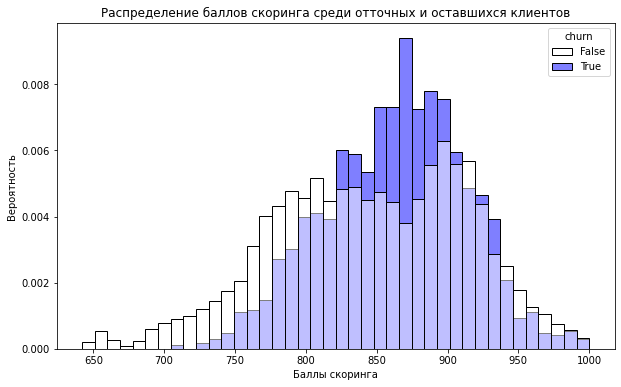

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='score',
stat='density', common_norm=False, palette='flag')
plt.xlabel('Баллы скоринга')
plt.ylabel('Вероятность')
plt.title('Распределение баллов скоринга среди отточных и оставшихся клиентов')

Отточность наблюдается среди клиентов с баллами в интервале от 830 до 910 баллов. Особенно высоко у клиентов с 870 баллами, что любопытно, так как это достаточно высокие баллы (а вот у клиентов с маленькими баллами, наоборот, не наблюдается отточности).

2) Распределение отточных и оставшихся клиентов по городам.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по городам')

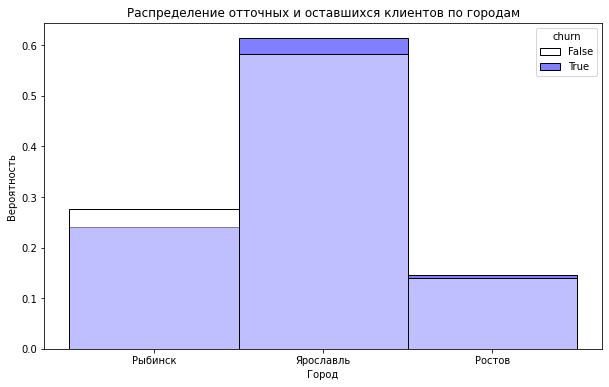

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='city',
stat='density', common_norm=False, palette='flag', discrete=True)
plt.xlabel('Город')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по городам')

Высокая вероятность оттока наблюдается среди клиентов из Ярославля, немного - из Ростова.

3) Распределение отточных и оставшихся клиентов по полу.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по полу')

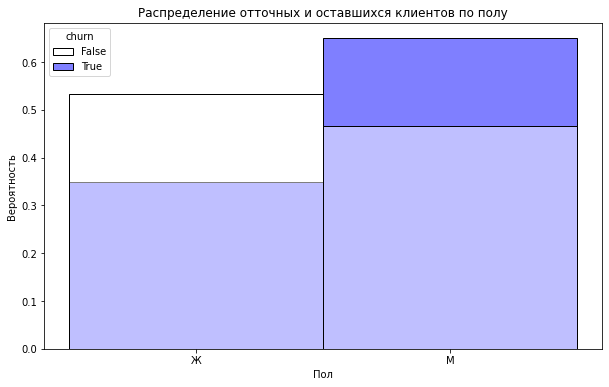

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='gender',
stat='density', common_norm=False, palette='flag', discrete=True)
plt.xlabel('Пол')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по полу')

Большая вероятность оттока наблюдается среди клиентов мужчин.

4) Распределение отточных и оставшихся клиентов по возрасту.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по возрасту')

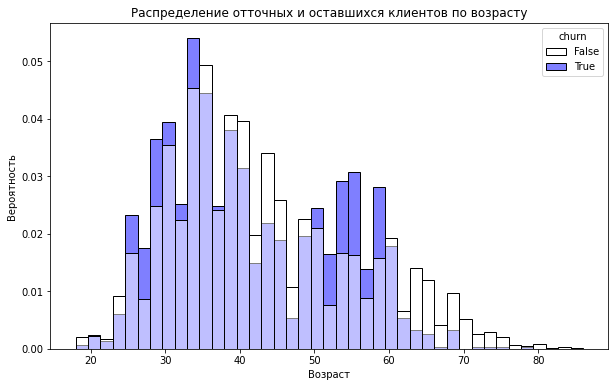

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='age',
stat='density', common_norm=False, palette='flag')
plt.xlabel('Возраст')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по возрасту')

Самая большая вероятность оттока наблюдается среди клиентов в районе от 28 до 34 лет и от 50 до 60 лет.

5) Распределение баллов собственности среди отточных и оставшихся клиентов.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по баллам собственности')

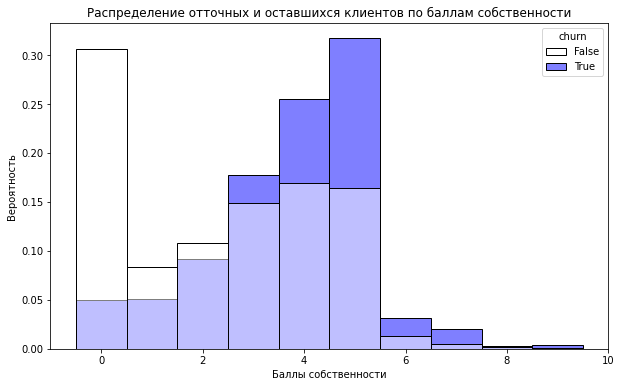

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='equity',
stat='density', common_norm=False, palette='flag', discrete=True)
plt.xlabel('Баллы собственности')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по баллам собственности')

Отток наблюдается у клиентов с 3 и выше баллами собственности.

6) Распределение отточных и оставшихся клиентов по балансу.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по количеству денег на счете')

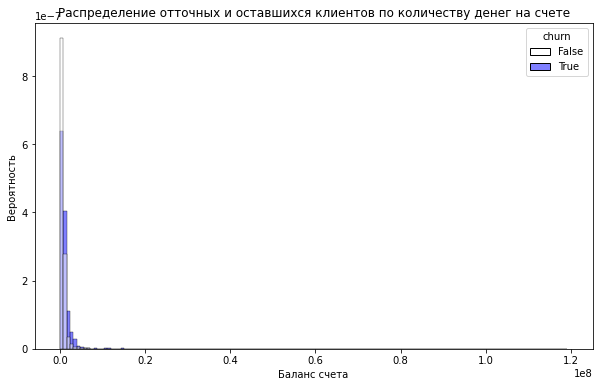

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='balance', bins=150,
stat='density', common_norm=False, palette='flag')
plt.xlabel('Баланс счета')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по количеству денег на счете')

У графика очень большой хвост, поэтому попробуем проанализировать основную часть, ограничив ось х 99-м перцентилем.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по количеству денег на счете')

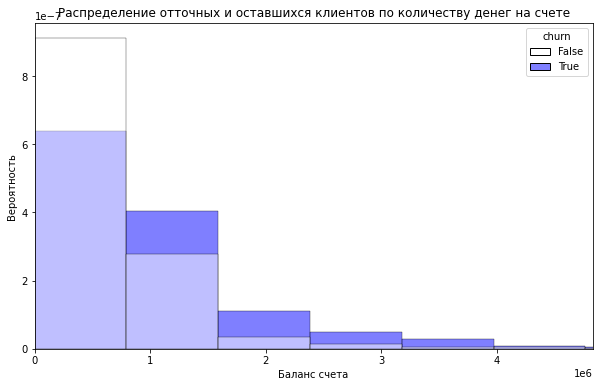

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='balance', bins=150,
stat='density', common_norm=False, palette='flag')

plt.xlim(0, data['balance'].quantile(0.99))
plt.xlabel('Баланс счета')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по количеству денег на счете')

Вероятность отток наблюдается среди клиентов с балансом от 1 миллиона и выше.

7) Распределение отточных и оставшихся клиентов по количеству продуктов.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по количеству продуктов')

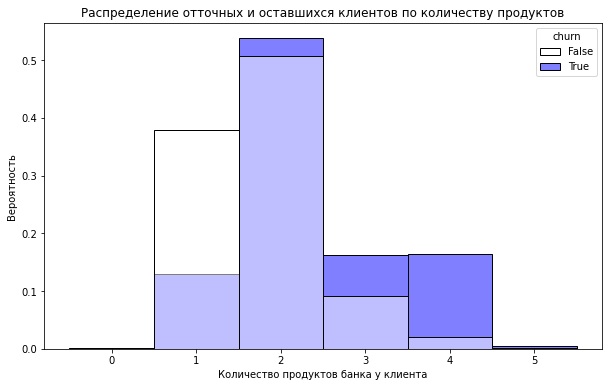

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='products',
stat='density', common_norm=False, palette='flag', discrete=True)
plt.xlabel('Количество продуктов банка у клиента')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по количеству продуктов')

Отток наблюдается у клиентов с 2-4 продуктами банка.

8) Распределение отточных и оставшихся клиентов по наличию или отсутствию кредитной карты.

In [32]:
data['credit_card'] = data['credit_card'].astype('str')

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по наличию или отсутствию кредитной карты')

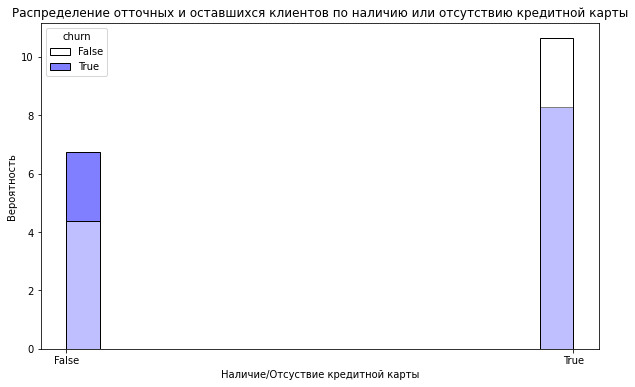

In [33]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='credit_card',
stat='density', common_norm=False, palette='flag', discrete=False)
plt.xlabel('Наличие/Отсуствие кредитной карты')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по наличию или отсутствию кредитной карты')

Вероятность оттока наблюдается у клиентов без кредитной карты.

9) Распределение отточных и оставшихся клиентов по наличию или отсутствию последней активности.

In [34]:
data['last_activity'] = data['last_activity'].astype('str')

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по наличию или отсутствию последней активности')

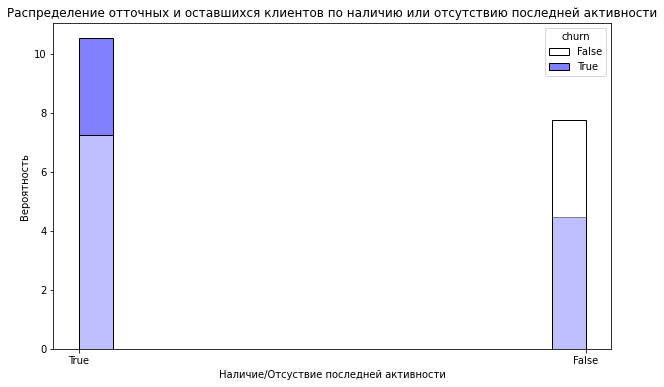

In [35]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='last_activity',
stat='density', common_norm=False, palette='flag', discrete=False)
plt.xlabel('Наличие/Отсуствие последней активности')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по наличию или отсутствию последней активности')

Высокая вероятность оттока среди клиентов, у которых была в последнее время какая-либо активность в банке.

10) Распределение отточных и оставшихся клиентов по оценочному доходу.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по оценочной зарплате')

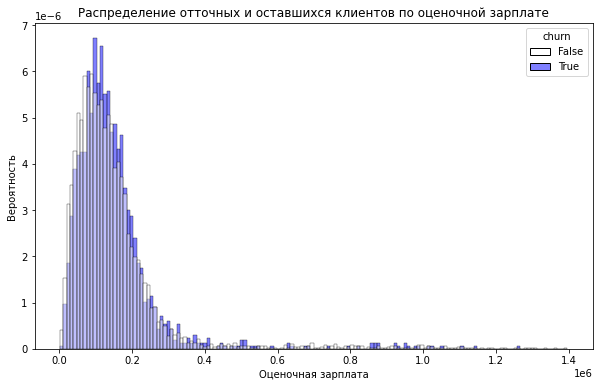

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='est_salary',
stat='density', common_norm=False, palette='flag')
plt.xlabel('Оценочная зарплата')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по оценочной зарплате')

У графика длинный хвост, попробуем проанализировать график, ограничив ось x 99-м перцентилем.

Text(0.5, 1.0, 'Распределение отточных и оставшихся клиентов по оценочной зарплате')

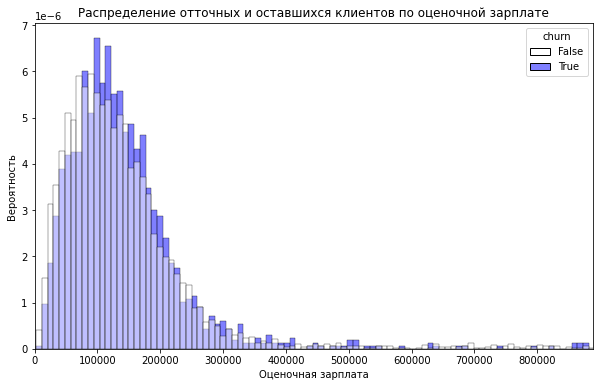

In [37]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, hue='churn', x='est_salary',
stat='density', common_norm=False, palette='flag')
plt.xlim(0,data['est_salary'].quantile(0.99))
plt.xlabel('Оценочная зарплата')
plt.ylabel('Вероятность')
plt.title('Распределение отточных и оставшихся клиентов по оценочной зарплате')

Отточность у клиентов с зарплатой в интервале от 100 000 до 150 000, от 170 000 до 210000

Сравнив отточных и оставшихся клиентов по ряду признаков, можно сделать вывод, что наибольшая вероятность оттока наблюдается у:

1) мужчин; 

2) в возрасте 28-34 и 50-60 лет; 

3) из города - Ярославль; 

4) с баллами скоринга в районе 830 – 910; 

5) с 3-5 баллами собственности; 

6) 2-мя и более продуктами банка; 

7) с балансом на счете больше 1 миллиона; 

8) без кредитной карты; 

9) с фиксированной последней активностью; 

10) оценочной заработной платой от 100 000 до 150 000 и от 170 000 до 210 000.

## Шаг 4. Сегментация.

На этом шаге нужно выделить несколько наиболее высокоотточных сегемнтов и дать по ним рекомендации.
Высокоотточность предполагает, что у таких сегментов процент оттока будет выше, чем средний отток по банку.

In [38]:
f"Средний отток по банку в процентах: {data['churn'].mean()*100}"

'Средний отток по банку в процентах: 18.2'

In [39]:
def seg_analysis(data):
    
    churn_mean = data['churn'].mean() * 100

    
    segments = {
        "seg1": data.query('gender == "М" and city == "Ярославль" and age >= 28 and age<=34 or\
         age >= 50 and age <=60 and score >= 830 and score<=910'),
        "seg2": data.query('gender == "М" and city == "Ярославль" and age >= 28 and age <=34 or\
        age >= 50 and age <=60 and equity >= 3 and equity <= 5'),
        "seg3": data.query('gender == "М" and city == "Ярославль" and age >= 28 and age<=34 or\
        age >= 50 and age <=60 and score >= 830 and score<=910 and credit_card == "False" and last_activity=="True"'),
        "seg4": data.query('gender == "М" and city == "Ярославль" and age >= 28 and age<=34 and\
        score >= 830 and score<=910 and est_salary >= 100000 and est_salary <= 150000 or est_salary >=170000 and est_salary<=210000'),
        "seg5": data.query('gender == "М" and city == "Ярославль" and age >= 28 and age<=34 or\
        age>=50 and age<=60 and score >= 830 and score<=910 and balance >= 1000000'),
        "seg6": data.query('gender == "М" and city == "Ярославль" and age >= 28 and age<=34 or\
        age>=50 and age<=60 and score >= 830 and score<=910 and products >= 2 and est_salary >= 100000 and\
        est_salary <= 150000 or est_salary >=170000 and est_salary<=210000'),
        "seg7": data.query('city == "Ярославль" and products >=2 and products <=5 and\
        last_activity == "True" and est_salary >= 100000 and est_salary <= 150000 or est_salary >=170000 and est_salary<=210000'),
        "seg8": data.query('city == "Ярославль" and equity >= 3 and equity <= 5 and credit_card == "False"'),
        "seg9": data.query('gender == "М" and age >= 28 and age<=34 or\
         age >= 50 and age <=60 and balance > 1000000 and last_activity == "True"'),
        "seg10": data.query('city == "Ярославль" and products >= 2 and products<=5 and last_activity == "True" and\
        est_salary >= 100000 and est_salary <= 150000 or est_salary >= 170000 and est_salary<=210000'),
        "seg11": data.query('gender == "М" and est_salary >= 100000 and\
        est_salary <= 150000 or est_salary >= 170000 and est_salary<=210000 and balance >= 1000000'),
        
        
    }

  
    result = []

    for segment_name, segment_data in segments.items():
        segment_size = len(segment_data)

       
        print(f"Сегмент {segment_name}: размер {segment_size}")

        
        if 500 <= segment_size <= 2000:
            segment_churn = segment_data['churn'].mean() * 100

           
            print(f"Сегмент {segment_name}: процент оттока {segment_churn:.1f}%")

            
            if segment_churn > churn_mean:
                result.append({
                    'segment': segment_name,
                    'size': segment_size,
                    'churn_rate': segment_churn
                })

    
    return pd.DataFrame(result)


result = seg_analysis(data)
print(result)

Сегмент seg1: размер 1575
Сегмент seg1: процент оттока 28.8%
Сегмент seg2: размер 1798
Сегмент seg2: процент оттока 30.5%
Сегмент seg3: размер 1024
Сегмент seg3: процент оттока 31.5%
Сегмент seg4: размер 1218
Сегмент seg4: процент оттока 22.5%
Сегмент seg5: размер 1041
Сегмент seg5: процент оттока 31.3%
Сегмент seg6: размер 2038
Сегмент seg7: размер 1624
Сегмент seg7: процент оттока 26.8%
Сегмент seg8: размер 1068
Сегмент seg8: процент оттока 35.5%
Сегмент seg9: размер 1506
Сегмент seg9: процент оттока 30.6%
Сегмент seg10: размер 1624
Сегмент seg10: процент оттока 26.8%
Сегмент seg11: размер 1535
Сегмент seg11: процент оттока 30.4%
  segment  size  churn_rate
0    seg1  1575        28.8
1    seg2  1798        30.5
2    seg3  1024        31.5
3    seg4  1218        22.5
4    seg5  1041        31.3
5    seg7  1624        26.8
6    seg8  1068        35.5
7    seg9  1506        30.6
8   seg10  1624        26.8
9   seg11  1535        30.4


Можно выделить несколько наиболее высокоотточных клиентов:

1) Клиенты из Ярославля с собственностью, не пользующиеся кредитной картой.

2) Мужчины из Ярославля в возрасте от 28 до 34 или от 50 до 60 лет с высокими баллами скоринга без кредитной карты с зафиксированной активностью в последнее время.

3) Мужчины из Ярославля в возрасте от 28 до 34 и 50 до 60 лет с высокими баллами скоринга и балансом счета более 1 миллиона.

4) Активные клиенты из Ярославля, пользующиеся несколькими продуктами банка (от 3 до 5) и с высоким уровнем заработной платы (от 100 000 до 150 000 или от 170 000 до 210 000)



Рекомендация для сегментов:

1. Клиенты из Ярославля с собственностью, не пользующиеся кредитной картой. Клиенты уходят именно из Ярославля, что может быть связано с несколькими причинами: неудобным расположением, низким качеством обслуживания, частыми техническими проблемами. Отсутствие кредитной карты может быть связано с невыгодными условиями по кредитки - возможно, стоит их пересмотреть. Наличие собственности может свидетельствовать о кредитоспособности клиенты (в случае кредита собственность может стать залогом), а это в свою очередь может говорить о невыгодных условиях кредитования.

2. Мужчины из Ярославля в возрасте от 28 до 34 или от 50 до 60 лет с высокими баллами скоринга без кредитной карты с зафиксированной активностью в последнее время.  Считается, что финансовые привычки мужчин и женщин отличаются, и мужчины более склонны рисковать и пробывать новые финансовые продукты, а также вкладывать деньги в выссокорискованные инвестиции. Возможно, это просто стереотип, однако банку стоит обратить внимание на то, что уход мужчин от них вероятнее, чем женщин. Уход наблюдается среди людей молодого возраста (от 28 до 34) и предпенсионного возраста (50-60 лет). Это либо люди со стабильной заработной платой, которые хотят, чтобы их деньги работали, поэтому либо ищут привлекательные условия по вкладам либо ищут более выгодные условия по кредиту, либо люди с накоплениями, которые ищут выгодные условия для вложения. Высокий уровень банковского скоринга, т.е. у таких клиентов хорошая кредитная история. Такие клиенты могут уходить из-за более выгодных предложений по кредиту и другим продуктам у конкурентам. Возможно, у конкурентов есть также дополнительные бонусы и скидки, что тоже может послужить причиной ухода. Насчет города - см. рекомендации по 1-му сегменту.

3. Мужчины из Ярославля в возрасте от 28 до 34 и 50 до 60 лет с высокими баллами скоринга и балансом счета более 1 миллиона. Тут рекомендации пересекаются с рекомендациями по 2-му сегменту. Стоит добавить про баланс на счете. Баланс на счете более 1000 000 рублей, значительные суммы, которые при правильном использовании могут приносить хорошие проценты. Возможно, конкуренты предлагают более привлекательные условия по вкладам, поэтому клиенты уходят.

4. Активные клиенты из Ярославля, пользующиеся несколькими продуктами банка (от 2 до 4) и с высоким уровнем заработной платы (от 100 000 до 150 000 или от 170 000 до 210 000. Клиенты пользуются продуктами банка (при чем несколькими), но все равно уходят. Стоит обратить внимания на условия конкурентов по основным продуктам, возможно, условия привлекательнее, поэтому клиенты уходят. Здесь также уходят клиенты с высоким уровнем зарплаты: есть свободые деньги, которые можно положить на счет или взять кредит и внести первый платеж. Стоит обратить внимание на условия кредитования и условия по вкладам. Насчет город - см. рекомендации по 1-му сегменту.


## Шаг 5. Статистический анализ.

1) Проверьте гипотезу различия дохода между теми клиентами, которые ушли и теми, которые остались.

**H0**: Средняя зарплата клиентов, которые ушли, и клиентов, которые остались, не отличается.

**H1**: Средняя зарплата клиентов, которые ушли, и клиентов, которые остались, отличается.

Сначала нужно проверить данные на нормальное распределение.

In [40]:
group_True = data.query("churn == True")["est_salary"]
group_False = data.query("churn == False")["est_salary"]

alpha = 0.01  

results = st.shapiro(group_True)
p_value = results[1]  

print('p-value: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

results2 = st.shapiro(group_False)
p_value = results[1] 
print('p-value: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

p-value:  0.0
Отвергаем нулевую гипотезу: распределение не нормально
p-value:  0.0
Отвергаем нулевую гипотезу: распределение не нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Ненормально распределение, поэтому применяем тест Манна Уитни.

In [41]:
stat, p_value = st.mannwhitneyu(group_True.dropna(), group_False.dropna())
print(f'p-value: {p_value}')
if p_value < 0.01:
    print("Отклоняем нулевую гипотезу. Существует статистически значимая разница в средней зарплате оставшихся и ушедших клиентов.")
else:
    print("Не отклоняем нулевую гипотезу. Между зарплату ушедших и оставшихся клиентов нет статистически значимой разницы.")

p-value: 0.000243559272811695
Отклоняем нулевую гипотезу. Существует статистически значимая разница в средней зарплате оставшихся и ушедших клиентов.


2) Проверьте гипотезу различия баланса счета между теми клиентами, которые ушли и теми, которые остались.

**H0:** Баланс счета клиентов, которые ушли, и клиентов, которые остались, не отличается.

**H1:** Баланс счета клиентов, которые ушли, и клиентов, которые остались, отличается.

Сначала нужно проверить данные на нормальное распределение.

In [42]:
group_True = data.query("churn == True")["balance"]
group_False = data.query("churn == False")["balance"]

alpha = 0.01  

results = st.shapiro(group_True)
p_value = results[1] 

print('p-value: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

results2 = st.shapiro(group_False)
p_value = results[1] 

print('p-value: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

p-value:  1.0
Не получилось отвергнуть нулевую гипотезу, распределение нормально
p-value:  1.0
Не получилось отвергнуть нулевую гипотезу, распределение нормально


/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Так как распределение нормально, применяем t-тест.

In [43]:
p_value = ttest_ind(group_True.dropna(), group_False.dropna()).pvalue
alpha = 0.01

print('p-значение: ', p_value)
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: баланс ушедших и оставшихся клиентов статистически различается.")
else:
    print("Не отвергаем нулевую гипотезу: не существует статистически значимой разницы между балансом оставшихся и ушедших клиентов")

p-значение:  5.2961006573922e-14
Отвергаем нулевую гипотезу: баланс ушедших и оставшихся клиентов статистически различается.


В результате анализа гипотез можно сделать следующие выводы:

1) Существует статистическая разница в средней зарплате оставшихся и ушедших клиентов.

2) Баланс ушедших и оставшихся клиентов статистически различается.

## Шаг 6. Презентация

Ссылка на презентацию: https://disk.yandex.ru/i/K1I2Vrp20diJDA

## Шаг 7. Общий вывод.

В результате анализа данных банка "Метанпром":

1) Осуществлена предобработка данных: изучены явные и неявные дубликаты; проанализированы пропуски в датасете; названия столбцов приведены к нижнему регистру; изменен тип данных в столбцах credit_card, last_activity, churn; проверены числовые значения на аномалии.

2) Проведен исследовательский анализ: проанализированы отточные и оставшиеся клиенты по ряду признаков. Наибольшая вероятность оттока наблюдается у: 1) мужчин; 2) в возрасте 28-34 и 50-60 лет; 3) из города - Ярославль; 4) с баллами скоринга в районе 830 – 910; 5) с 3-5 баллами собственности; 6) 2-мя и более продуктами банка; 7) с балансом на счете больше 1 миллиона; 8) без кредитной карты; 9) с фиксированной последней активностью; 10) оценочной заработной платой от 100 000 до 150 000 и от 170 000 до 210 000.

3) Осуществлена сгементация и выделено 4 высокоотточных сегмента. Даны рекомедации по снижению оттока.

4) Проведен статистический анализ, проанализировано 2 гипотезы. Существует статистическая разница в средней зарплате оставшихся и ушедших клиентов. Баланс ушедших и оставшихся клиентов статистически различается.